In [57]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import skimage.feature
import pandas as pd
%matplotlib inline

# Patch Extraction Example  
I use blob detection to extract the dotted-area in the image

In [60]:
# data initialization
file_names = [str(x) + '.jpg' for x in range(0,3)]
classes = ["adult_males", "subadult_males", "adult_females", "juveniles", "pups"]
coordinates_df = pd.DataFrame(index=file_names, columns=classes)


In [61]:
# get coordinates
for filename in file_names:

    # read the Train and Train Dotted images
    image_1 = cv2.imread("./data/train-dotted/" + filename)
    image_2 = cv2.imread("./data/train/" + filename)

    # absolute difference between Train and Train Dotted
    image_3 = cv2.absdiff(image_1,image_2)

    # mask out blackened regions from Train Dotted
    mask_1 = cv2.cvtColor(image_1, cv2.COLOR_BGR2GRAY)
    mask_1[mask_1 < 20] = 0
    mask_1[mask_1 > 0] = 255

    mask_2 = cv2.cvtColor(image_2, cv2.COLOR_BGR2GRAY)
    mask_2[mask_2 < 20] = 0
    mask_2[mask_2 > 0] = 255

    image_3 = cv2.bitwise_or(image_3, image_3, mask=mask_1)
    image_3 = cv2.bitwise_or(image_3, image_3, mask=mask_2) 

    # convert to grayscale to be accepted by skimage.feature.blob_log
    image_3 = cv2.cvtColor(image_3, cv2.COLOR_BGR2GRAY)

    # detect blobs
    blobs = skimage.feature.blob_log(image_3, min_sigma=3, max_sigma=4, num_sigma=1, threshold=0.02)

    adult_males = []
    subadult_males = []
    pups = []
    juveniles = []
    adult_females = [] 

    for blob in blobs:
        # get the coordinates for each blob
        y, x, s = blob
        # get the color of the pixel from Train Dotted in the center of the blob
        g,b,r = image_1[int(y)][int(x)][:]

        # decision tree to pick the class of the blob by looking at the color in Train Dotted
        if r > 200 and g < 50 and b < 50: # RED
            adult_males.append((int(x),int(y)))        
        elif r > 200 and g > 200 and b < 50: # MAGENTA
            subadult_males.append((int(x),int(y)))         
        elif r < 100 and g < 100 and 150 < b < 200: # GREEN
            pups.append((int(x),int(y)))
        elif r < 100 and  100 < g and b < 100: # BLUE
            juveniles.append((int(x),int(y))) 
        elif r < 150 and g < 50 and b < 100:  # BROWN
            adult_females.append((int(x),int(y)))

    coordinates_df["adult_males"][filename] = adult_males
    coordinates_df["subadult_males"][filename] = subadult_males
    coordinates_df["adult_females"][filename] = adult_females
    coordinates_df["juveniles"][filename] = juveniles
    coordinates_df["pups"][filename] = pups
    
    print("%s completes..."%filename)

0.jpg completes...
1.jpg completes...
2.jpg completes...


In [62]:
# extract 50 x 50 patches
x = []
y = []
for filename in file_names:    
    image = cv2.imread("./data/train/" + filename)
    for lion_class in classes:
        for coordinates in coordinates_df[lion_class][filename]:
            thumb = image[coordinates[1]-25:coordinates[1]+25,coordinates[0]-25:coordinates[0]+25,:]
            if np.shape(thumb) == (50, 50, 3):
                x.append(thumb)
                y.append(lion_class)
x = np.array(x)
y = np.array(y)

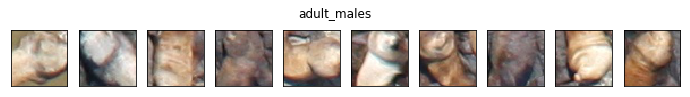

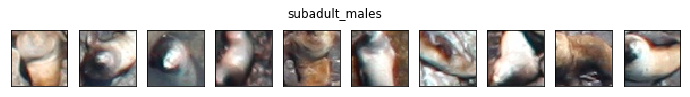

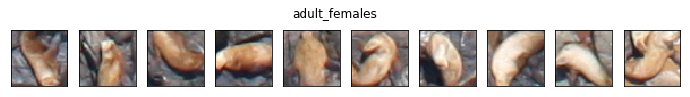

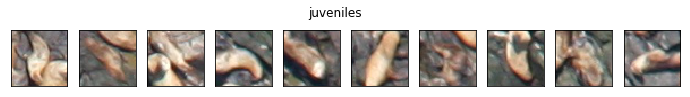

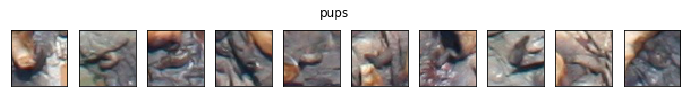

In [63]:
# plot examples
for lion_class in classes:
    f, ax = plt.subplots(1,10,figsize=(12,1.5))
    f.suptitle(lion_class)
    axes = ax.flatten()
    j = 0
    for a in axes:
        a.set_xticks([])
        a.set_yticks([])
        for i in range(j,len(x)):
            if y[i] == lion_class:
                j = i+1
                a.imshow(cv2.cvtColor(x[i], cv2.COLOR_BGR2RGB))
                break

In [79]:
coordinates_df.to_csv('./coordinates.csv')

In [74]:
def calculate_error(n):
    error = 0
    for i in range(n):
        standard = stat_df.iloc[i][1:]
        calculate = list(map(lambda x: len(x), list(coordinates_df.iloc[i])))
        error += sum(abs(standard - calculate))
    return error 

In [75]:
stat_df = pd.read_csv('./train.csv')

In [77]:
calculate_error(3)

2

In [82]:
x.shape

(1032, 50, 50, 3)

In [81]:
y

array(['adult_males', 'adult_males', 'adult_males', ..., 'juveniles',
       'juveniles', 'juveniles'],
      dtype='<U14')

In [87]:
from keras.datasets import mnist

# Load pre-shuffled MNIST data into train and test sets
(X_train, y_train), (X_test, y_test) = mnist.load_data()

11493376/11490434 [==============================] - 5s 0us/step


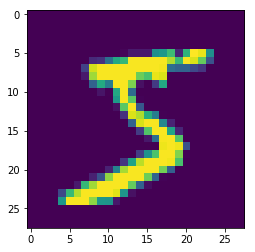

In [89]:
from matplotlib import pyplot as plt
plt.imshow(X_train[0])

In [111]:
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1)
X_test = X_test.reshape(X_test.shape[0],28, 28, 1)
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255

In [112]:
Y_train = np_utils.to_categorical(y_train, 10)
Y_test = np_utils.to_categorical(y_test, 10)

In [113]:
Y_train.shape

(60000, 10)

In [117]:
model = Sequential()

model.add(Convolution2D(32, (3, 3), activation='relu', input_shape=(28,28,1)))
model.add(Convolution2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
# model.add(Dense(128, activation='relu'))
# model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))

In [118]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [119]:
model.fit(X_train, Y_train, 
          batch_size=32, epochs=5, verbose=1)

Epoch 1/5
60000/60000 [==============================] - 121s 2ms/step - loss: 0.6694 - acc: 0.7971
Epoch 2/5
60000/60000 [==============================] - 122s 2ms/step - loss: 0.3388 - acc: 0.9009
Epoch 3/5
60000/60000 [==============================] - 124s 2ms/step - loss: 0.2990 - acc: 0.9136 0s - loss: 0.2993 - 
Epoch 4/5
60000/60000 [==============================] - 131s 2ms/step - loss: 0.2549 - acc: 0.9256
Epoch 5/5
60000/60000 [==============================] - 133s 2ms/step - loss: 0.2164 - acc: 0.9369


In [120]:
score = model.evaluate(X_test, Y_test, verbose=0)

In [121]:
score

[0.16663776340186595, 0.95130000000000003]

In [123]:
X_test.shape

(10000, 28, 28, 1)

In [124]:
model.metrics_names

['loss', 'acc']